In [1]:
import typing
import io
import os
from torch import nn
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from Sources.ViT.models.modeling import VisionTransformer, CONFIGS

from Sources.callbacks import plot_confusion_matrix
from Sources.CoAtNet import CoAtNet
from torch.nn import functional as F
from Sources.callbacks import get_true_classes
from Sources.callbacks import get_predicted_classes
from Sources.callbacks import get_classes_probs
from Sources.callbacks import callback
from Sources.data_tools import ImageDataset
from torch.utils.data import DataLoader

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
import io
from pytorch_lightning.callbacks import Callback
from datetime import datetime, date, time
from PIL import Image
import itertools 
from sklearn.model_selection import train_test_split
import torchvision.models as models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

labels_map = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

Using cuda device


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset('../Data/burnasyan_Br.csv', 'train_paths.txt', transform = transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to(device)
train_labels = train_labels.to(device)

val_dataset = ImageDataset('../Data/burnasyan_Br.csv', 'val_paths.txt', transform = transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
val_features, val_labels = next(iter(val_dataloader))
val_features = val_features.to(device)
val_labels = val_labels.to(device)

In [5]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

In [6]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.eval()
None

In [7]:
model.head

Linear(in_features=768, out_features=1000, bias=True)

In [8]:
model.head = nn.Linear(768, 3)

In [9]:
model.head

Linear(in_features=768, out_features=3, bias=True)

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

model.to(device)
None

/tmp/ipykernel_12636/62302592.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [11]:
logdir = "../Logits/ViT_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [12]:
writer = SummaryWriter(logdir)
vit_callback = callback()
weight = torch.tensor([0.33, 0.03, 0.63])
weight = weight.pow(-1)
weight = weight.to(device)
criterion = nn.CrossEntropyLoss(weight=weight, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

In [13]:
epochs_num = 300

for epoch in tqdm_notebook(range(epochs_num), desc='epochs'):  # loop over the dataset multiple times
    
    vit_callback.on_epoch_begin(epoch) 
    
    running_loss = 0.0
    
    classes = []
    true_classes= []

    for data in tqdm_notebook(train_dataloader, desc='one epoch training'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        true_classes.append(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)[0]
        classes.append(nn.Softmax(dim=1)(outputs))
        outputs = outputs.to(device)
        outputs = torch.nn.Sigmoid()(outputs)
        # print(outputs.shape(), labels.shape())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    running_loss /= len(true_classes)
    
    val_classes = []
    val_true_classes = []
    val_loss = 0.0
    
    for data in tqdm_notebook(val_dataloader, desc='validation'):
        # get the inputs; data is a list of [inputs, labels]
        val_inputs, val_labels = data
        val_true_classes.append(val_labels)
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
    
        # forward 
        with torch.no_grad():
            val_outputs = model(val_inputs)[0]
            val_classes.append(nn.Softmax(dim=1)(val_outputs))
            val_outputs = val_outputs.to(device)
            val_outputs = torch.nn.Sigmoid()(val_outputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
        
    val_loss /= len(val_true_classes)

    vit_callback.on_epoch_end(true_classes, classes, val_true_classes, val_classes,
                          ["Benign", "InSitu", "Invasive"],
                          running_loss, val_loss, writer)
    
    if epoch % 50 == 0:
        torch.save(model.state_dict(), "../Logits/SavedNN/Saved_ViT/" + str(epoch))

print('Finished Training')

epochs:   0%|          | 0/300 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

/home/anna/Desktop/workenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

one epoch training:   0%|          | 0/1577 [00:00<?, ?it/s]

validation:   0%|          | 0/657 [00:00<?, ?it/s]

Finished Training


## Visualizing

In [10]:
# Prepare Model
model.load_state_dict(torch.load("../Logits/SavedNN/Saved_ViT/" + str(150)))
model.eval()

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: 1
torch.Size([224, 224, 3])


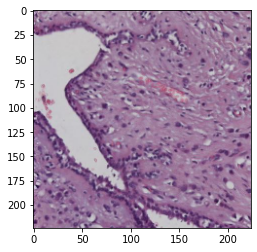

Label: 2


In [12]:
transform_for_maps = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = ImageDataset('../Data/burnasyan_Br.csv', 'val_paths.txt', transform = transform_for_maps)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {len(labels)}")
img = features[0].squeeze().permute(1, 2, 0).int()
print(img.shape)
label = labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [16]:
transform = transforms.Compose([
#     transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

im = features[0]
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [32]:
x.unsqueeze(0).size()

torch.Size([1, 3, 224, 224])

In [43]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#print(mask)

### size = 14 * 14

In [44]:
mask /= mask.max()
#print(mask)

In [45]:
mask = cv2.resize(mask, (224, 224))[..., np.newaxis]
result = (mask * im.permute(1, 2, 0).detach().numpy()).astype("uint8")

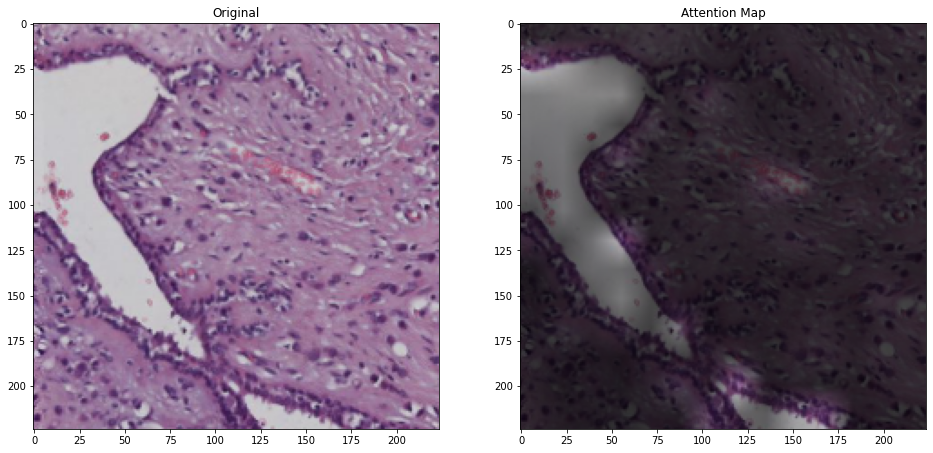

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(result)

In [16]:
print(val_classes[0])

tensor([[0.0976, 0.6139, 0.2884],
        [0.0742, 0.6542, 0.2716],
        [0.0837, 0.6017, 0.3145],
        [0.0720, 0.6734, 0.2545],
        [0.0871, 0.6183, 0.2947],
        [0.0295, 0.7679, 0.2026],
        [0.0458, 0.8460, 0.1082],
        [0.0886, 0.6399, 0.2715],
        [0.1007, 0.5701, 0.3292],
        [0.0631, 0.6750, 0.2619],
        [0.0788, 0.6826, 0.2386],
        [0.0889, 0.5363, 0.3748],
        [0.0992, 0.6152, 0.2856],
        [0.0636, 0.6941, 0.2423],
        [0.0600, 0.7578, 0.1822],
        [0.0134, 0.9235, 0.0631]], device='cuda:0')


In [17]:
print(val_true_classes[0])

tensor([2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2])
